# DCGAN(Deep Convolution Generative Adversial Networks) -  Tensorflow 2.0

Made by Song GH with Tensorflow 2.0<br>
Paper URL : https://arxiv.org/abs/1511.06434

## 0. Abstract

- In this work we hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning.
- We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning. 
- Training on various image datasets, we show convincing evidence that our deep convolutional adversarial pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator.

## 1. Introduction

- GANs provide an attractive alternative to maximum likelihood techniques
- GANs have been known to be unstable to train, often resulting in generators that produce nonsensical outputs.
- Following Contribute
 - Convolutional GANs that make them stable to train in most settings.
 - We use the trained discriminators for image classification tasks
 - generators have interesting vector arithmetic properties allowing for easy manipulation of many semantic qualities of generated samples.
 

## 2. Related Work
### 2.1 Representation Learning from unlabeled Data
### 2.2 Generating Natural Images : parametric and non-parametric
### 2.3 Visualizing the Internals of CNNs

## 3. Approach and Model Architecture

### Core to Approach 3 Changes
1. CNN replace pooling -> strides convolution
2. eliminating fully connected layers on top of convolutional features
 - We found global average pooling increased model stability but hurt convergence speed.
 - <b>The first layer of the GAN</b>, which takes <b>a uniform noise distribution Z as input</b>, could be called fully connected ... but the result is <b>reshaped into a 4-dimensional tensor</b> and used as the <b>start of the convolution stack</b>.
 - For the <b>discriminator, the last convolution layer is flattened and then fed into a single sigmoid output.</b>
 
3. <b>Batch Normalization (Ioffe & Szegedy, 2015)</b> which stabilizes learning by normalizing the input to each unit to have <b>zero mean and unit variance. </b>
 - This helps deal with training problems that arise due to poor initialization and helps gradient flow in deeper models ...
 -<b> Directly applying batchnorm to all layers however, resulted in sample oscillation and model instability. This was avoided by <font color='blue'>not applying batchnorm to the generator output layer and the discriminator input layer.</font></b>

- <b> The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the <font color='blue'>Tanh function.</font></b>
- Within the <b> discriminator</b> we found the <b> leaky rectified activation (Maas et al., 2013) (Xu et al., 2015)</b> to work well, especially for higher resolution modeling. This is in contrast to the original GAN paper, which used the maxout activation (Goodfellow et al., 2013).

### Architecture guidelines for stable Deep Convolutional GANs
 - <b> Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
 - Use batchnorm in both the generator and the discriminator.
 - Remove fully connected hidden layers for deeper architectures.
 - Use ReLU activation in generator for all layers except for the output, which uses Tanh.
 - Use LeakyReLU activation in the discriminator for all layers.</b>

## 4. Details of Adversarial Training

- 3 Dataset = Large-scale Scene Understanding (LSUN) (Yu et al., 2015), Imagenet-1k and a newly assembled Faces dataset
- <b>No pre-processing was applied to training images...</b>
- <b>All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128.
- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.
- In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
- Adam optimizer </b>
 - suggested <font color='blue'><b>learning rate</font></b> of 0.001, to be too high, using <font color='blue'><b>0.0002</font></b> instead
 - <font color='blue'><b>momentum term Beta 1</font></b> at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to <font color='blue'><b>0.5</font></b> helped stabilize training.

<img src='./DCGAN Paper Figure/dcgan figure1.png'>

# 3 Dataset : 1. MNIST 2. CelebA 3. CIFAR10

# 1. MNIST

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

2.0.0-alpha0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from IPython import display

In [3]:
(train_images, train_labels),_ = tf.keras.datasets.mnist.load_data()
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


### mini-batch-size=128 paper 3 page last paragraph -> 256

In [4]:
train_images_num = train_images.shape[0]
BATCH_SIZE = 256 # mini-batch-size=128 paper 3 page last paragraph -> 256

In [5]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - (255./2)) / (255./2) #Normalize [-1, 1]
# train_images = train_images / 255. #Normalize [0,1]

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images_num).batch(BATCH_SIZE)

In [7]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        # Paper wrote no fully connected layers are used but for reshape I use dense layer once in first.
        # can't 100Z -> reshape [7,7,256]
        self.dense = layers.Dense(7*7*256, use_bias=False,
                                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                 input_shape=(100,))
        self.BatchNorm0 = layers.BatchNormalization()
        self.activation0 = layers.ReLU()
        
        self.reshape = layers.Reshape((7,7,256))
        
        
        self.conv1 = layers.Conv2DTranspose(128, (5,5), strides=1, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))
        self.BatchNorm1 = layers.BatchNormalization()
        self.activation1 = layers.ReLU()        
        
        
        self.conv2 = layers.Conv2DTranspose(64, (5,5), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.ReLU()        
        
        
        self.conv3 = layers.Conv2DTranspose(1, (4,4), strides=2, padding='same', use_bias=False, 
                                            activation='tanh',
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))        
        
        
    def call(self, inputs, training=True):
        #inputs = [1,1,100] = 100 z : 100 dimension uniform distribution
        model = self.dense(inputs) #[100,] -> [7*7*256,]
        model = self.BatchNorm0(model, training=training)
        model = self.activation0(model)
                
        model = self.reshape(model) # [7*7*256,] -> [None, 7, 7, 256]        
        
        model = self.conv1(model) # [None, 7, 7, 256] -> [None, 7, 7, 128]
        model = self.BatchNorm1(model, training=training)
        model = self.activation1(model)
        
        model = self.conv2(model) # [None, 7, 7, 128] -> [None, 14, 14, 64]
        model = self.BatchNorm2(model, training=training)
        model = self.activation2(model)
        
        # paper wrote not using batchnorm generator output layer
        # to avoid sample oscillation and model instability
        # Wrote in Chapter 3 - Core 3 Changes Batchnorm paragraph last sentence
        model = self.conv3(model) # [None, 14, 14, 64] -> [None, 28, 28, 1]
        
        return model
    

(1, 28, 28, 1)
(28, 28, 1)


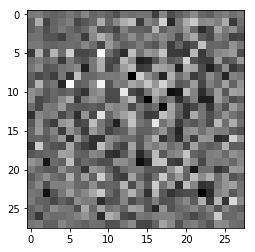

In [8]:
generator = Generator()

# uniform noise distribution Z
Z = tf.random.uniform([1,100])
generated_image = generator(Z, training=False)
print(generated_image.shape)
print(generated_image[0].shape)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                  input_shape=(28,28,1))
        # paper wrote not using batchnorm discriminator input layer
        # to avoid sample oscillation and model instability
        # Wrote in Chapter 3 - Core 3 Changes Batchnorm paragraph last sentence
        #self.BatchNorm1 = layers.BatchNormalization() 
        self.activation1 = layers.LeakyReLU(alpha=0.2)
        
        self.conv2 = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.LeakyReLU(alpha=0.2)
        
        self.conv3 = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm3 = layers.BatchNormalization()
        self.activation3 = layers.LeakyReLU(alpha=0.2)
        
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)
        """
         논문 3장 Core 3 Changes 두 번째 마지막 문장을 보면 
         For the discriminator, the last convolution layer is flattened and then fed into a single sigmoid output.
         으로 적혀있다. 때문에 아래와 같이 Dense layer에 activation='sigmoid'를 사용하던지 혹은 
         그냥 tf.keras.activations.sigmoid()를 사용하는 방법이 있다.
         
         하지만 실험 결과 학습이 안됨...
         생성 이미지에 대한 logit이 0이면 가짜, 1이면 진짜로 판단해야하지만
         막 생성한 이미지에 대해서도 sigmoid를 통과시키면 0으로 판단해야할 것을 
         sigmoid(0) = 0.5 근처가 되므로 학습이 안되는 당연한 결과를 맞이함
         
         물론 다른 곳에서는 되는 곳들도 있던데 ... 원인은 찾지 못함
         
        """
        # self.dense = layers.Dense(1, activation='sigdmoid')
        
    def call(self, inputs, training=True):
        logit = self.conv1(inputs)
        #logit = self.BatchNorm1(logit)
        logit = self.activation1(logit) # (1, 14, 14, 64)
        
        logit = self.conv2(logit)
        logit = self.BatchNorm2(logit, training=training)
        logit = self.activation2(logit) # (1, 7, 7, 128)
        
        logit = self.conv3(logit)
        logit = self.BatchNorm3(logit, training=training)
        logit = self.activation3(logit) # (1, 4, 4, 256)
                
        logit = self.flatten(logit)
        logit = self.dense(logit)
        
        return logit

In [10]:
discriminator = Discriminator()
print(discriminator(generated_image))

tf.Tensor([[0.06261594]], shape=(1, 1), dtype=float32)


In [11]:
generator = Generator()
discriminator = Discriminator()

BCE = tf.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_logits):
    return BCE(tf.ones_like(fake_logits), fake_logits)

def discriminator_loss(real_logits, fake_logits):
    real = BCE(tf.ones_like(real_logits), real_logits)
    fake = BCE(tf.zeros_like(fake_logits), fake_logits)
    tot = real + fake
    #print('real:',real, 'fake:',fake)
    return tot

generator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)

noise_dimension = 100
number_of_generator_images = 8

save_images_noise = tf.random.normal([number_of_generator_images, noise_dimension]) # 16,100

@tf.function
def train(batch_image):
    noise = tf.random.uniform([BATCH_SIZE, noise_dimension]) #128x100
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_logits = discriminator(batch_image, training=True)
        fake_logits = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)
        
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    
    #return gen_loss, disc_loss

In [12]:
if not os.path.isdir('./mnist_image'):
    os.makedirs('./mnist_image')

In [13]:
def save_images(generator, noise_input, epoch):
    images = generator(noise_input, training=False)
    fig = plt.figure(figsize=(8, 5))    
    fig.suptitle('Epoch:{:04d}'.format(epoch), fontsize='x-large')
    for i in range(images.shape[0]):
        plt.subplot(2,4,i+1)
        plt.title('image {:02d}th'.format(i))
        # If train_images = (train_images - (255./2)) / (255./2) 
        # Normalize [-1, 1]일 때의 DeNormalization
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')      
        
        # If train_images = train_images / 255. 
        #Normalize [0,1]이라면 DeNormalization은
        # plt.imshow(images[i, :, :, 0] * 255)
        
        plt.axis('off')
    
    plt.tight_layout()    
    plt.savefig('./mnist_image/mnist_epoch_{:03d}.png'.format(epoch))    
    plt.show()    

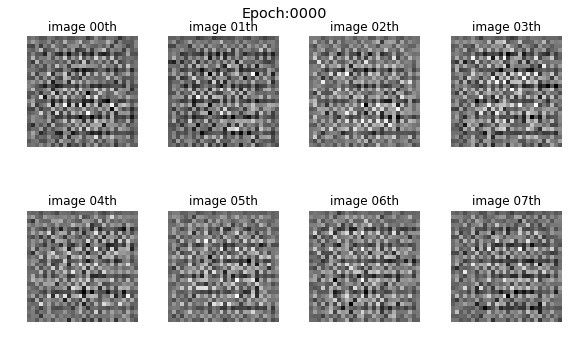

In [14]:
save_images(generator, save_images_noise, 0)

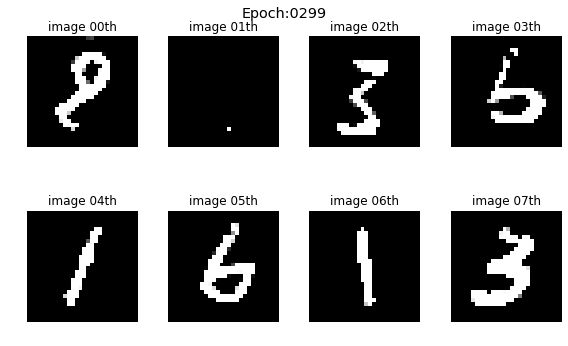

Epoch : 299 => Time: 11.04333209991455
Final Image


In [15]:
epochs = 300

for epoch in range(epochs):
    start = time.time()
    
    for image_batch in train_dataset:
        train(image_batch)      
    
    display.clear_output(wait=True)
    save_images(generator, save_images_noise, epoch)
    print('Epoch :', epoch ,'=> Time:', time.time()-start)
    
print('Final Image')

In [16]:
import glob
import imageio

print(glob.glob('./mnist_image/mnist_epoch*.png')[:10])

['./mnist_image\\mnist_epoch_000.png', './mnist_image\\mnist_epoch_001.png', './mnist_image\\mnist_epoch_002.png', './mnist_image\\mnist_epoch_003.png', './mnist_image\\mnist_epoch_004.png', './mnist_image\\mnist_epoch_005.png', './mnist_image\\mnist_epoch_006.png', './mnist_image\\mnist_epoch_007.png', './mnist_image\\mnist_epoch_008.png', './mnist_image\\mnist_epoch_009.png']


In [17]:
#imageio.get_writer : https://imageio.readthedocs.io/en/stable/userapi.html
#mode='I' => multiple images

with imageio.get_writer('DCGAN_mnist.gif', mode='I') as writer:
    file_list = sorted(glob.glob('./mnist_image/mnist_epoch*.png'))
    
    for i, image_file in enumerate(file_list):
        image = imageio.imread(image_file)
        writer.append_data(image)    

# 2. CelebA

data : https://www.kaggle.com/jessicali9530/celeba-dataset

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from IPython import display

import glob
import imageio

import cv2

In [19]:
celeb_path = 'E:\\kaggle\\celeba-dataset\\img_align_celeba'
celeb_files = os.listdir(celeb_path)
celebImages = []

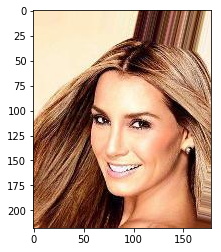

In [20]:
images = cv2.imread(celeb_path +'\\'+ celeb_files[0])
plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))

In [21]:
print(images.shape)

(218, 178, 3)


In [22]:
print(cv2.cvtColor(images, cv2.COLOR_BGR2RGB).shape)

(218, 178, 3)


In [23]:
for i in range(10000):
    images = cv2.imread(celeb_path +'\\'+ celeb_files[i])
    images = cv2.resize(cv2.cvtColor(images, cv2.COLOR_BGR2RGB), (64, 64))
    celebImages.append(images)

In [24]:
train_images = np.array(celebImages).astype('float32')
print(train_images.shape)

(10000, 64, 64, 3)


In [25]:
train_images_num = train_images.shape[0]
BATCH_SIZE = 256 # mini-batch-size=128 paper 3 page last paragraph -> 256
train_images = (train_images - (255./2)) / (255./2) #Normalize [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images_num).batch(BATCH_SIZE)

In [26]:
class Generator(tf.keras.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        # Paper wrote no fully connected layers are used but for reshape I use dense layer once in first.
        # can't 100Z -> reshape [4,4,1024]
        self.dense = layers.Dense(4*4*1024, use_bias=False,
                                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                 input_shape=(100,))
        self.BatchNorm0 = layers.BatchNormalization()
        self.activation0 = layers.ReLU()
        
        self.reshape = layers.Reshape((4,4,1024))
        
        
        self.conv1 = layers.Conv2DTranspose(512, (4,4), strides=1, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))
        self.BatchNorm1 = layers.BatchNormalization()
        self.activation1 = layers.ReLU()        
        
        
        self.conv2 = layers.Conv2DTranspose(256, (4,4), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.ReLU()        
        
        self.conv3 = layers.Conv2DTranspose(128, (4,4), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm3 = layers.BatchNormalization()
        self.activation3 = layers.ReLU()    
        
        self.conv4 = layers.Conv2DTranspose(128, (4,4), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm4 = layers.BatchNormalization()
        self.activation4 = layers.ReLU()
             

        self.conv5 = layers.Conv2DTranspose(3, (4,4), strides=2, padding='same', use_bias=False, 
                                            activation='tanh',
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))  
    
    def call(self, inputs, training=True):
        #inputs = [1,1,100] = 100 z : 100 dimension uniform distribution
        model = self.dense(inputs) #[100,] -> [4*4*1024,]
        model = self.BatchNorm0(model, training=training)
        model = self.activation0(model)
                
        model = self.reshape(model) # [4*4*1024,] -> [None, 4, 4, 1024]        
        
        model = self.conv1(model) # [None, 4, 4, 1024] -> [None, 8, 8, 512]
        model = self.BatchNorm1(model, training=training)
        model = self.activation1(model)
        
        model = self.conv2(model) # [None, 8, 8, 512] -> [None, 16, 16, 256]
        model = self.BatchNorm2(model, training=training)
        model = self.activation2(model)
        
        model = self.conv3(model) # [None, 16, 16, 256] -> [None, 32, 32, 128]
        model = self.BatchNorm3(model, training=training)
        model = self.activation3(model)
        
        model = self.conv4(model) # [None, 32, 32, 256] -> [None, 64, 64, 128]
        model = self.BatchNorm4(model, training=training)
        model = self.activation4(model)
       
        model = self.conv5(model) # [None, 32, 32, 128] -> [None, 64, 64, 3]
        
        return model
    

(1, 64, 64, 3)
(64, 64, 3)


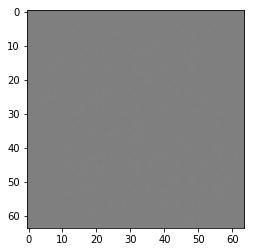

In [27]:
generator = Generator()

# uniform noise distribution Z
Z = tf.random.uniform([1,100])
generated_image = generator(Z, training=False)
print(generated_image.shape)
print(generated_image[0].shape)
plt.imshow(np.array((generated_image[0] * 127.5 + 127.5),np.int32))

In [28]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                  input_shape=(64, 64, 3))
        self.activation1 = layers.LeakyReLU(alpha=0.2)
        
        self.conv2 = layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.LeakyReLU(alpha=0.2)
        
        self.conv3 = layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm3 = layers.BatchNormalization()
        self.activation3 = layers.LeakyReLU(alpha=0.2)
        
        self.conv4 = layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm4 = layers.BatchNormalization()
        self.activation4 = layers.LeakyReLU(alpha=0.2)
        
        
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)
        
    def call(self, inputs, training=True):
        
        logit = self.conv1(inputs)
        logit = self.activation1(logit) # (1, 32, 32, 128)
        
        logit = self.conv2(logit)
        logit = self.BatchNorm2(logit, training=training)
        logit = self.activation2(logit) # (1, 16, 16, 256)
        
        logit = self.conv3(logit)
        logit = self.BatchNorm3(logit, training=training)
        logit = self.activation3(logit) # (1, 8, 8, 512)
        
        logit = self.conv4(logit)
        logit = self.BatchNorm4(logit, training=training)
        logit = self.activation4(logit) # (1, 4, 4, 256)
               
        logit = self.flatten(logit)        
        logit = self.dense(logit)
        
        return logit
    
    
    """
    ValueError: Input 0 of layer dense_24 is incompatible with the layer: 
    expected axis -1 of input shape to have value 16384 but received input with shape [256, 4096]
    16384 = 4 * 4096
    """

In [29]:
discriminator = Discriminator()
print(discriminator(generated_image))

tf.Tensor([[0.07621311]], shape=(1, 1), dtype=float32)


In [30]:
generator = Generator()
discriminator = Discriminator()

BCE = tf.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_logits):
    return BCE(tf.ones_like(fake_logits), fake_logits)

def discriminator_loss(real_logits, fake_logits):
    real = BCE(tf.ones_like(real_logits), real_logits)
    fake = BCE(tf.zeros_like(fake_logits), fake_logits)
    tot = real + fake
    #print('real:',real, 'fake:',fake)
    return tot

generator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)

noise_dimension = 100
number_of_generator_images = 8

save_images_noise = tf.random.normal([number_of_generator_images, noise_dimension]) # 8,100

@tf.function
def train(batch_image):
    noise = tf.random.uniform([BATCH_SIZE, noise_dimension]) #128x100
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_logits = discriminator(batch_image, training=True)
        fake_logits = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)
        
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    
    #return gen_loss, disc_loss

In [31]:
if not os.path.isdir('./celeb_image'):
    os.makedirs('./celeb_image')

In [32]:
def save_images(generator, noise_input, epoch):
    images = generator(noise_input, training=False)
    fig = plt.figure(figsize=(8, 5))    
    fig.suptitle('Epoch:{:04d}'.format(epoch), fontsize='x-large')
    
    for i in range(images.shape[0]):
        plt.subplot(2,4,i+1)
        plt.imshow(np.array((images[i] * 127.5 + 127.5), np.int32))           
        plt.axis('off')
    
    plt.tight_layout()    
    plt.savefig('./celeb_image/celeb_epoch_{:03d}.png'.format(epoch))    
    plt.show()  

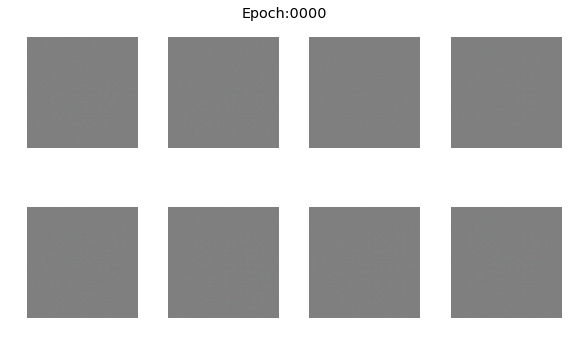

In [33]:
save_images(generator, save_images_noise, 0)

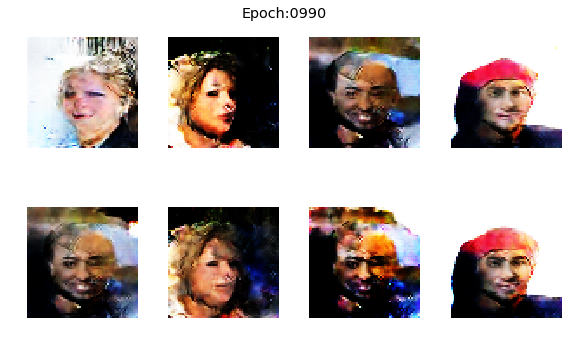

Epoch : 990 => Time: 34.64437651634216
Epoch : 991 => Time: 34.35217213630676
Epoch : 992 => Time: 34.24943208694458
Epoch : 993 => Time: 34.49101448059082
Epoch : 994 => Time: 33.14538240432739
Epoch : 995 => Time: 32.97284555435181
Epoch : 996 => Time: 33.0815544128418
Epoch : 997 => Time: 33.0376718044281
Epoch : 998 => Time: 33.12942624092102
Epoch : 999 => Time: 32.987805128097534


In [34]:
epochs = 1000

for epoch in range(epochs):
    start = time.time()
    
    for image_batch in train_dataset:
        train(image_batch)      
    
    if epoch % 10 == 0:
        display.clear_output(wait=True)
        save_images(generator, save_images_noise, epoch)
    print('Epoch :', epoch ,'=> Time:', time.time()-start)    

In [35]:
with imageio.get_writer('DCGAN_celeba.gif', mode='I') as writer:
    file_list = sorted(glob.glob('./celeb_image/celeb_epoch*.png'))
    
    for i, image_file in enumerate(file_list):
        image = imageio.imread(image_file)
        writer.append_data(image)    

# 3. CIFAR 10

keras dataset

(50000, 32, 32, 3)


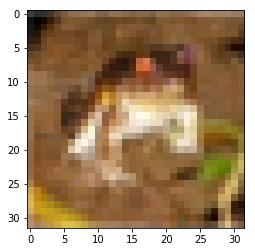

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

(train_images, y_train), _ = cifar10.load_data()
print(train_images.shape)
plt.imshow(train_images[0])

In [4]:
train_images_num = train_images.shape[0]
BATCH_SIZE = 256 # mini-batch-size=128 paper 3 page last paragraph -> 256
train_images = tf.cast((train_images - (255./2)) / (255./2), tf.float32) #Normalize [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images_num).batch(BATCH_SIZE)

In [5]:
class Generator(tf.keras.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        # Paper wrote no fully connected layers are used but for reshape I use dense layer once in first.
        # can't 100Z -> reshape [4,4,1024]
        self.dense = layers.Dense(4*4*1024, use_bias=False,
                                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                 input_shape=(100,))
        self.BatchNorm0 = layers.BatchNormalization()
        self.activation0 = layers.ReLU()
        
        self.reshape = layers.Reshape((4,4,1024))
        
        
        self.conv1 = layers.Conv2DTranspose(512, (4,4), strides=1, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))
        self.BatchNorm1 = layers.BatchNormalization()
        self.activation1 = layers.ReLU()        
        
        
        self.conv2 = layers.Conv2DTranspose(256, (4,4), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.ReLU()        
        
        self.conv3 = layers.Conv2DTranspose(128, (4,4), strides=2, padding='same', use_bias=False,
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))       
        self.BatchNorm3 = layers.BatchNormalization()
        self.activation3 = layers.ReLU()                 

        self.conv5 = layers.Conv2DTranspose(3, (4,4), strides=2, padding='same', use_bias=False, 
                                            activation='tanh',
                                           kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,
                                                                                                stddev=0.02))  
    
    def call(self, inputs, training=True):
        #inputs = [1,1,100] = 100 z : 100 dimension uniform distribution
        model = self.dense(inputs) #[100,] -> [4*4*1024,]
        model = self.BatchNorm0(model, training=training)
        model = self.activation0(model)
                
        model = self.reshape(model) # [4*4*1024,] -> [None, 4, 4, 1024]        
        
        model = self.conv1(model) # [None, 4, 4, 1024] -> [None, 8, 8, 512]
        model = self.BatchNorm1(model, training=training)
        model = self.activation1(model)
        
        model = self.conv2(model) # [None, 8, 8, 512] -> [None, 16, 16, 256]
        model = self.BatchNorm2(model, training=training)
        model = self.activation2(model)
        
        model = self.conv3(model) # [None, 16, 16, 256] -> [None, 32, 32, 128]
        model = self.BatchNorm3(model, training=training)
        model = self.activation3(model)
        
        model = self.conv5(model) # [None, 32, 32, 128] -> [None, 64, 64, 3]
        
        return model    

(1, 32, 32, 3)
(32, 32, 3)


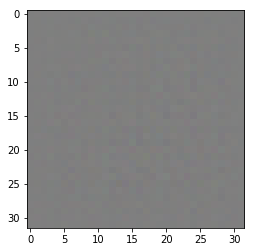

In [6]:
generator = Generator()

# uniform noise distribution Z
Z = tf.random.uniform([1,100])
generated_image = generator(Z, training=False)
print(generated_image.shape)
print(generated_image[0].shape)
plt.imshow(np.array((generated_image[0] * 127.5 + 127.5),np.int32))

In [7]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02),
                                  input_shape=(32, 32, 3))
        self.activation1 = layers.LeakyReLU(alpha=0.2)
        
        self.conv2 = layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm2 = layers.BatchNormalization()
        self.activation2 = layers.LeakyReLU(alpha=0.2)
        
        self.conv3 = layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm3 = layers.BatchNormalization()
        self.activation3 = layers.LeakyReLU(alpha=0.2)
        
        self.conv4 = layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='same',
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02))
        self.BatchNorm4 = layers.BatchNormalization()
        self.activation4 = layers.LeakyReLU(alpha=0.2)
        
        
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)
        
    def call(self, inputs, training=True):
        
        logit = self.conv1(inputs)
        logit = self.activation1(logit) # (1, 32, 32, 128)
        
        logit = self.conv2(logit)
        logit = self.BatchNorm2(logit, training=training)
        logit = self.activation2(logit) # (1, 16, 16, 256)
        
        logit = self.conv3(logit)
        logit = self.BatchNorm3(logit, training=training)
        logit = self.activation3(logit) # (1, 8, 8, 512)
        
        logit = self.conv4(logit)
        logit = self.BatchNorm4(logit, training=training)
        logit = self.activation4(logit) # (1, 4, 4, 256)
               
        logit = self.flatten(logit)        
        logit = self.dense(logit)
        
        return logit

In [8]:
discriminator = Discriminator()
print(discriminator(generated_image))

tf.Tensor([[0.17339122]], shape=(1, 1), dtype=float32)


In [9]:
generator = Generator()
discriminator = Discriminator()

BCE = tf.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_logits):
    return BCE(tf.ones_like(fake_logits), fake_logits)

def discriminator_loss(real_logits, fake_logits):
    real = BCE(tf.ones_like(real_logits), real_logits)
    fake = BCE(tf.zeros_like(fake_logits), fake_logits)
    tot = real + fake
    #print('real:',real, 'fake:',fake)
    return tot

generator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5)

noise_dimension = 100
number_of_generator_images = 8

save_images_noise = tf.random.normal([number_of_generator_images, noise_dimension]) # 8,100

@tf.function
def train(batch_image):
    noise = tf.random.uniform([BATCH_SIZE, noise_dimension]) #128x100
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_logits = discriminator(batch_image, training=True)
        fake_logits = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)
        
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    
    #return gen_loss, disc_loss

In [10]:
if not os.path.isdir('./cifar_image'):
    os.makedirs('./cifar_image')

In [11]:
def save_images(generator, noise_input, epoch):
    images = generator(noise_input, training=False)
    fig = plt.figure(figsize=(8, 5))    
    fig.suptitle('Epoch:{:04d}'.format(epoch), fontsize='x-large')
    images = np.array((images * 127.5 + 127.5), dtype=np.int32)
    
    for i in range(images.shape[0]):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i])           
        plt.axis('off')
    
    plt.tight_layout()    
    plt.savefig('./cifar_image/cifar_epoch_{:03d}.png'.format(epoch))    
    plt.show()  

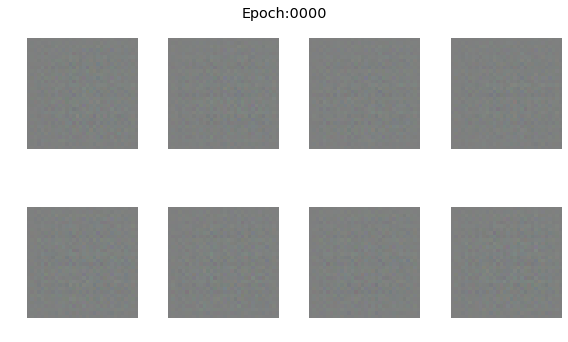

In [12]:
save_images(generator, save_images_noise, 0)

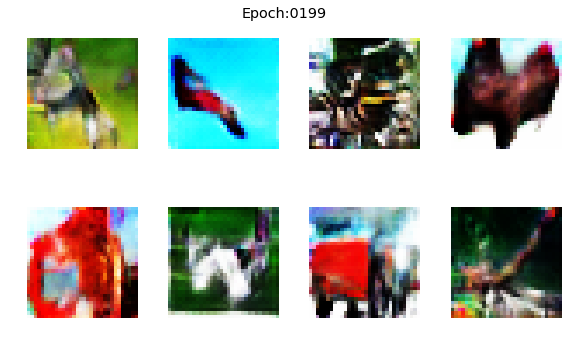

Epoch : 199 => Time: 59.36730909347534


In [13]:
epochs = 200

for epoch in range(epochs):
    start = time.time()
    
    for image_batch in train_dataset:
        train(image_batch)
    if epoch % 10 == 0 or epoch == epochs-1:    
        display.clear_output(wait=True)
        save_images(generator, save_images_noise, epoch)
    print('Epoch :', epoch ,'=> Time:', time.time()-start)   

In [15]:
import glob
import imageio

In [16]:
with imageio.get_writer('DCGAN_cifar.gif', mode='I') as writer:
    file_list = sorted(glob.glob('./cifar_image/cifar_epoch*.png'))
    
    for i, image_file in enumerate(file_list):
        image = imageio.imread(image_file)
        writer.append_data(image)    